<a href="https://colab.research.google.com/github/abrarfayez/Head-Pose-Estimation/blob/main/HeadPoseEstimation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [634]:
%%capture
!pip install mediapipe

# **Imports**

In [941]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
import glob
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#models
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# **Helper Functions**

In [920]:
def test_imj(path,frame=False):
  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    if frame:
      image = path
    else:
      image = cv2.imread(path)
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    landmark_x_y = []
    
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
        for landmark in face.landmark:
          x = landmark.x
          y = landmark.y
                    
          # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
          shape = image.shape 
          relative_x = int(x * shape[1])
          relative_y = int(y * shape[0])
          landmark_x_y.extend([relative_x,relative_y])
      
  return landmark_x_y,image

In [636]:
def get_pyr(img):
  '''This function extracts the 3 angles pitch, yaw and roll and return them'''

  mat_file = sio.loadmat('/content/AFLW2000/'+img.split('.')[0]+'.mat')
  # extracting the labels 3 angels
  return mat_file["Pose_Para"][0][:3]

In [728]:
def training_model_metrics(model, X, y,model_name):
  models = []
  for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.iloc[:,i].values, test_size=0.2)
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    print(f'Model name: {model_name}'+f"\t Angle: {y.iloc[:,i].name}")
    print("Test_acc: ",model.score(X_test,y_test))
    print("Train_acc: ",model.score(X_train,y_train))
    print(f'RMSE: {mean_squared_error(y_test, ypred)}\n')
    models.append(model)
  return models

In [638]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

# **Reading data**

In [639]:
from zipfile import ZipFile

with ZipFile('/content/AFLW2000-3D.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [877]:
images_path = "/content/AFLW2000/"
faceModule = mediapipe.solutions.face_mesh
features = []
labels = []
for img in os.listdir(images_path) :
  if img.endswith(".jpg"):
    with faceModule.FaceMesh(static_image_mode=True) as faces:
      image = cv2.imread(images_path+img)
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      landmark_x_y = []
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
          for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])

            landmark_x_y.extend([relative_x,relative_y])
            cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
          features.append(landmark_x_y)
          labels.append(get_pyr(img))

print(np.array(features).shape)

(1853, 936)


In [866]:
print(np.array(labels).shape)

(1853, 3)


# **Preprocessing**

In [687]:
def preprocess(df):

  # Centeralizing data relative to the nose
  df.iloc[:,0::2] = df.iloc[:,0::2].sub(df[2], axis = 0)
  df.iloc[:,1::2] = df.iloc[:,1::2].sub(df[3], axis = 0)

  #Standralizing the data
  norm_vector = np.sqrt((df[14]-df[2])**2+(df[15]-df[3])**2).values.reshape(-1,1)
  df = df.div(norm_vector, axis=0)

  return df


In [689]:
df = pd.DataFrame(features)
df = preprocess(df)
df = pd.concat([df,pd.DataFrame(labels,columns=["pitch","yaw","roll"])], axis=1)
df.head()

0         1    2    3         4         5         6         7  \
0  0.038168  0.407123  0.0  0.0  0.025445  0.139949 -0.089058 -0.381678   
1  0.267579  0.352078  0.0  0.0  0.253496  0.070416  0.014083 -0.436576   
2  0.027715  0.221719  0.0  0.0  0.009238  0.046191 -0.101621 -0.332579   
3  0.089271  0.410649  0.0  0.0  0.160689  0.142834  0.124980 -0.428503   
4 -0.317162  0.578354  0.0  0.0 -0.018657  0.298505  0.354475 -0.391788   

          8         9  ...       929       930       931       932       933  \
0  0.000000 -0.127226  ... -0.636130  0.216284 -0.623408  0.903305 -0.776079   
1 -0.042249 -0.112665  ... -0.915402  0.506992 -0.859070  1.281563 -1.084399   
2 -0.009238 -0.092383  ... -0.683634  0.101621 -0.646681  0.618966 -0.868400   
3  0.017854 -0.124980  ... -0.624900  0.678463 -0.607046  1.499761 -0.517775   
4  0.111940 -0.149253  ... -0.093283  1.063425 -0.149253  1.977598  0.485071   

        934       935     pitch       yaw      roll  
0  0.954195 -0.814247  0.075391  0.066288 -0.076080  
1  1.366062 -1.211147 -0.514121  0.752342 -0.341487  
2  0.655919 -0.905353 -0.347319 -0.027759 -0.091287  
3  1.589032 -0.553483 -0.029032  0.567679  0.240908  
4  2.126851  0.503728  0.442086  0.223025  0.786156  

[5 rows x 939 columns]

# **Training**

In [649]:
X = df.drop(["pitch","yaw","roll"], axis=1)
y = df.iloc[:,-3:]

In [801]:
xg_reg = xgb.XGBRegressor()
svr = SVR(kernel='poly')
rf = RandomForestRegressor()

In [808]:
svr_models = training_model_metrics(svr,X,y,"SVR")

Model name: SVR	 Angle: pitch
Test_acc:  0.05197010734765828
Train_acc:  0.3084398477950049
RMSE: 0.691907111946739

Model name: SVR	 Angle: yaw
Test_acc:  0.9380701160481032
Train_acc:  0.8489025326003532
RMSE: 0.01853209735716327

Model name: SVR	 Angle: roll
Test_acc:  0.1871814485364739
Train_acc:  0.35680632870435103
RMSE: 0.6739636254946549



In [810]:
xg_models1 = training_model_metrics(xg_reg,X,y,"XGboost")

[01:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model name: XGboost	 Angle: pitch
Test_acc:  0.662391710811859
Train_acc:  0.9668118165532151
RMSE: 0.02774482498928444

[01:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model name: XGboost	 Angle: yaw
Test_acc:  0.9034517484503822
Train_acc:  0.9815366048007056
RMSE: 0.03454617809222153

[01:27:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model name: XGboost	 Angle: roll
Test_acc:  0.9575028022376724
Train_acc:  0.9738341986087047
RMSE: 0.03770939928977596



# **Predict**

In [922]:
def predict(img,frame=False):
  features1,image=test_imj(img,frame)
  df1 = preprocess(pd.DataFrame(np.array(features1).reshape(1,-1)))

  pitch_predicator,yaw_predicator,roll_predicator = xg_models1
  pitch = pitch_predicator.predict(df1.values)
  yaw = yaw_predicator.predict(df1.values)
  roll = roll_predicator.predict(df1.values)

  # nose position --> (features[2],features[3])

  return draw_axis(image,pitch,yaw,roll,features1[2],features1[3])

**Test on images**

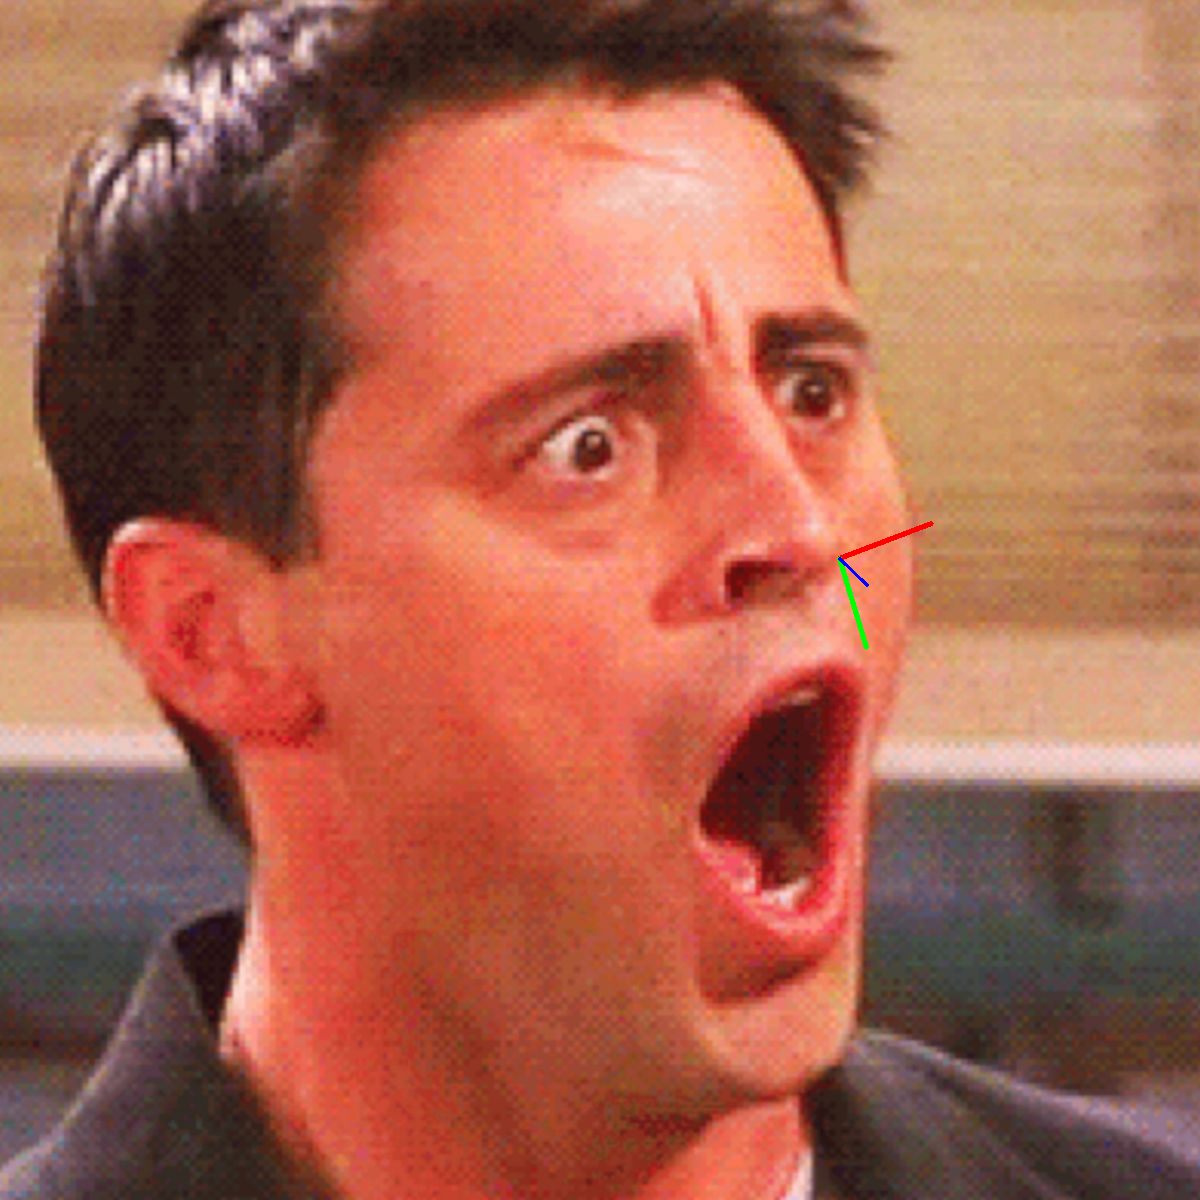

In [887]:
cv2_imshow(predict("/content/joey1.jpg"))

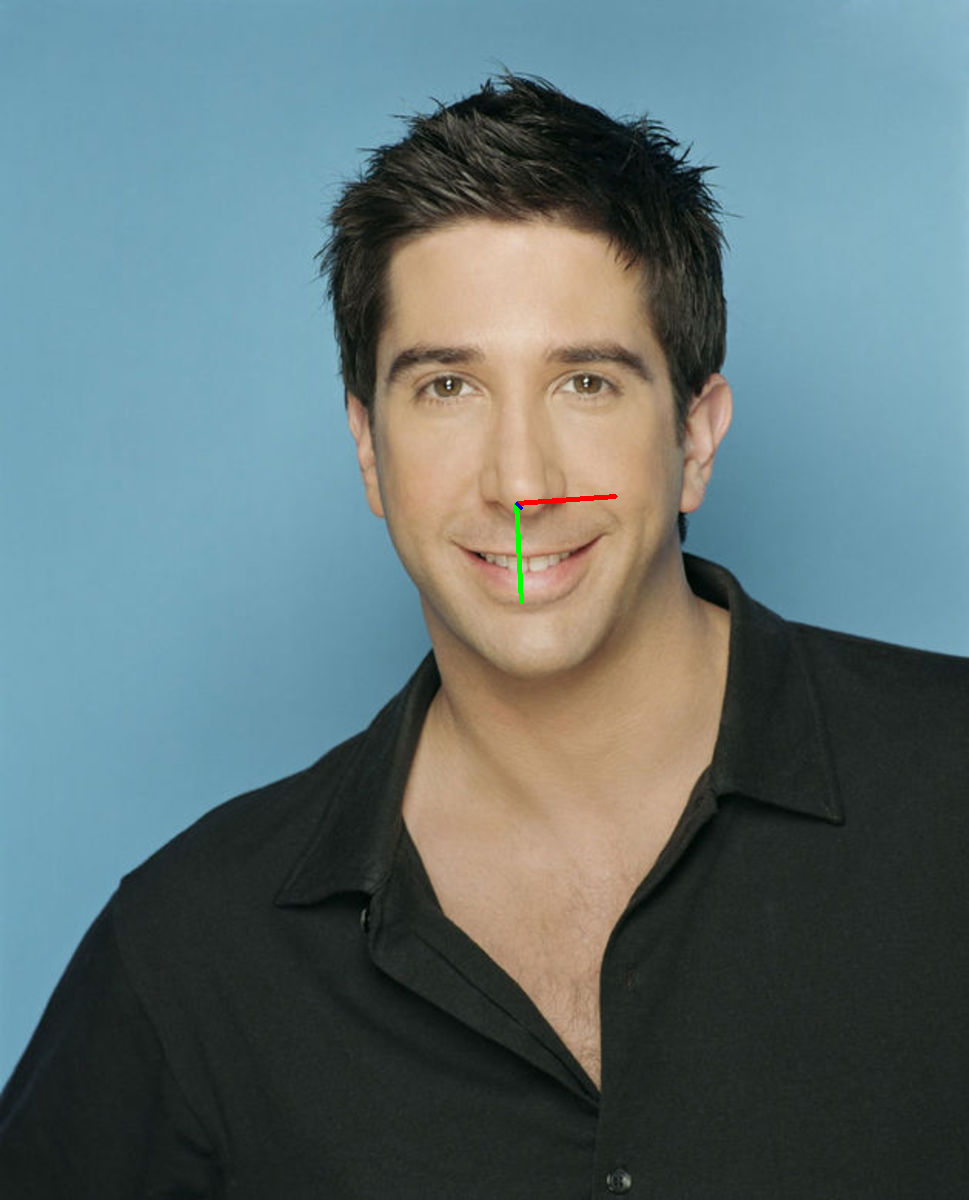

In [861]:
cv2_imshow(predict("/content/img2.jpg"))

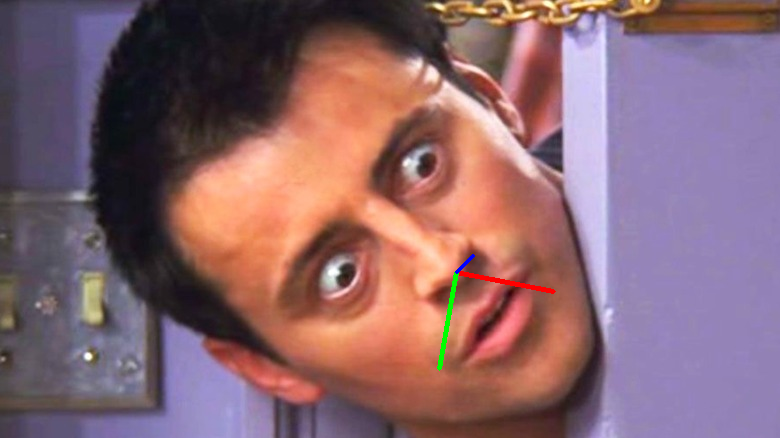

In [888]:
cv2_imshow(predict("/content/joey2.jpg"))

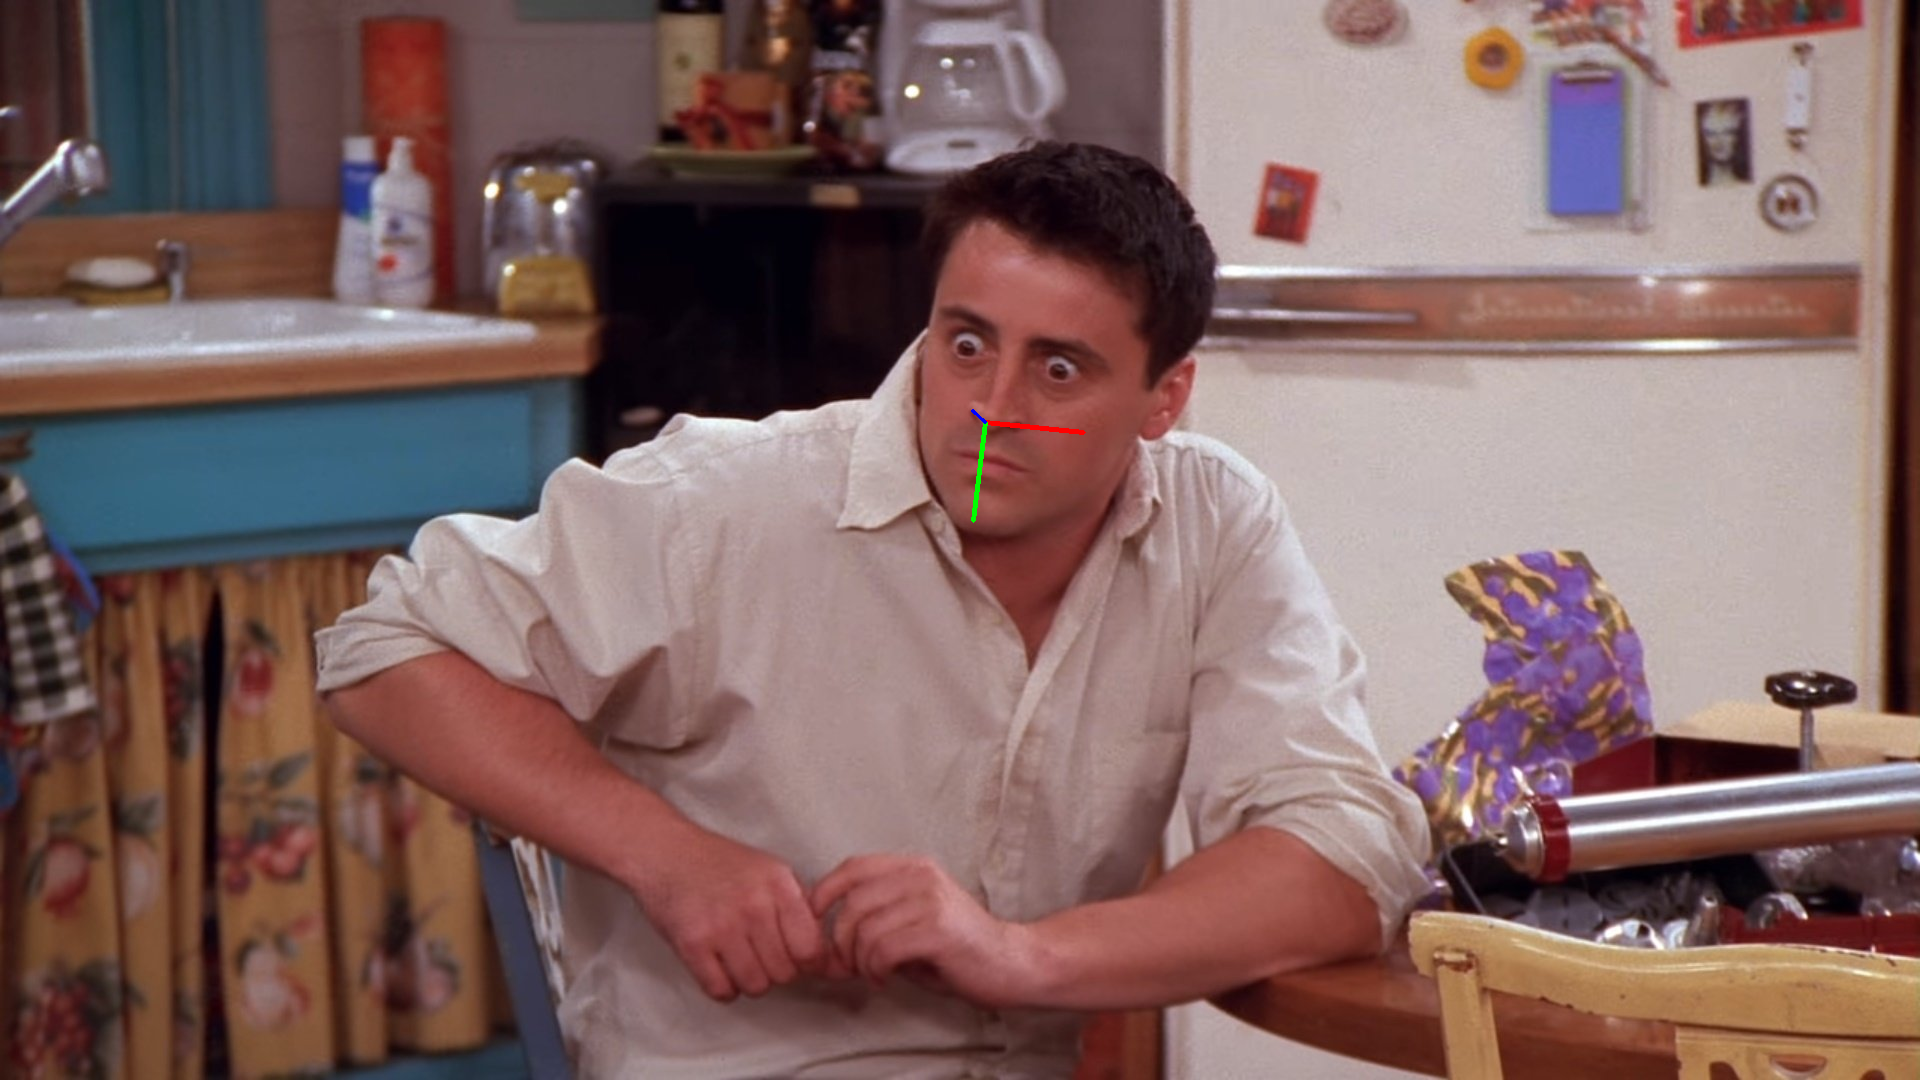

In [889]:
cv2_imshow(predict("/content/joey3.jpg"))

Test on video

In [ ]:
def video_test(video_path):
  cap = cv2.VideoCapture(video_path)
  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))
  result = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'XVID'),10, (frame_width, frame_height))
  
  ret,frame = cap.read()
  while ret:
    
    result.write(predict(frame,True))
    ret, frame = cap.read()
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


  cap.release()
  result.release()
  cv2.destroyAllWindows()

    

video_test("/content/v3.mp4")